### Initializing the API Handler

You should set the access parameters in the `local.py` of the project.

In [1]:
import twitter
from local import *
api = None
if CONSUMER_KEY:
    api = twitter.Api(
        consumer_key=CONSUMER_KEY,
        consumer_secret=CONSUMER_SECRET,
        access_token_key=ACCESS_TOKEN_KEY,
        access_token_secret=ACCESS_TOKEN_SECRET,
        sleep_on_rate_limit=True)

We have chosen 85 accounts to be analysed for this project.

In [16]:
from accounts import accounts
print("Number of accounts:", len(accounts))

Number of accounts: 85


### Fetching/Loading the Data

By default, this code loads previously fetched data from the data folder, unless it doesn't find the file related to an account. You can force to fetch even when the file exists by passing `from_internet_even_if_local_exists=True`.

By default, after fetching, this function stores the related data into a file for the account. You can disable this behavior by passing `save=False`.

In [17]:
for account in accounts:
    try:
        f = account.fetch(api, from_internet_even_if_local_exists=False, save=True)
        if f:
            print("Fetched", account)
        else:
            print("Loaded", account)
    except:
        import sys
        print("Unexpected error for", account, ':', sys.exc_info()[0])

Loaded Ashraf Ghani 🇦🇫
Loaded MFA Afghanistan 🇦🇫
Loaded Mahmoud Saikal 🇦🇫
Loaded Afghanistan Mission 🇦🇫
Loaded Mauricio Macri 🇦🇷
Loaded Jorge Faurie 🇦🇷
Loaded Argentina at the United Nations 🇦🇷
Loaded Scott Morrison 🇦🇺
Loaded Marise Payne 🇦🇺
Loaded Gillian Bird 🇦🇺
Loaded Michel Temer 🇧🇷
Loaded Aloysio Nunes 🇧🇷
Loaded Itamaraty Brazil 🇧🇷
Loaded Brazil Mission UN 🇧🇷
Loaded Justin Trudeau 🇨🇦
Loaded CanadianPM 🇨🇦
Loaded Chrystia Freeland 🇨🇦
Loaded Marc-Andre Blanchard 🇨🇦
Loaded Chinese Mission to UN 🇨🇳
Loaded Jean-Claude Juncker 🇪🇺
Loaded Federica Mogherini 🇪🇺
Loaded ValedeAlmeidaEU 🇪🇺
Loaded European External Action Service 🇪🇺
Loaded Emmanuel Macron 🇫🇷
Loaded Jean-Yves Le Drian 🇫🇷
Loaded La France à l'ONU 🇫🇷
Loaded Angela Merkel 🇩🇪
Loaded Heiko Maas 🇩🇪
Loaded GermanForeignOffice 🇩🇪
Loaded German Mission to UN 🇩🇪
Loaded Narendra Modi 🇮🇳
Loaded Sushma Swaraj 🇮🇳
Loaded Syed Akbaruddin 🇮🇳
Loaded Joko Widodo 🇮🇩
Loaded Menteri Luar Negeri 🇮🇩
Loaded D.T. Djani 🇮🇩
Loaded Hassan Rouhani 🇮🇷
Fetched

### Grouping the Accounts Based on the Country They Represent

In [4]:
countries = {}
for account in accounts:
    c = account.country_representing
    if account.country_representing:
        if c not in countries:
            countries[c] = [account]
        else:
            countries[c].append(account)

### Creating the Graph of Countries Following Each Other

To create a graph aggregating how the grouped accounts are following each other, we set the weight of a connection from country `c1` to country `c2` equal to the percentage of the number of `c1` accounts being followed by a `c1` account, averaged for all the `c1` accounts.

In [5]:
c2c = {(c1, c2):0 for c1 in countries.keys() for c2 in countries.keys()}
for a1 in accounts:
    c1 = a1.country_representing
    if c1 not in countries:
        continue
    a1_screen_name = a1.twitter_handler.lower()
    for a2 in accounts:
        c2 = a2.country_representing
        if c2 not in countries:
            continue
        for f in a2.followings:
            if f.screen_name.lower() == a1_screen_name:
                c2c[(c2, c1)] += 1 / len(countries[c2]) / len(countries[c1])

To draw the graph, we use [networkx](https://networkx.github.io/) library.
Using the [`spring_layout`](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html),
we're creating a visualization where the proximity shows how members of the countries follow each other.

<IPython.core.display.Javascript object>


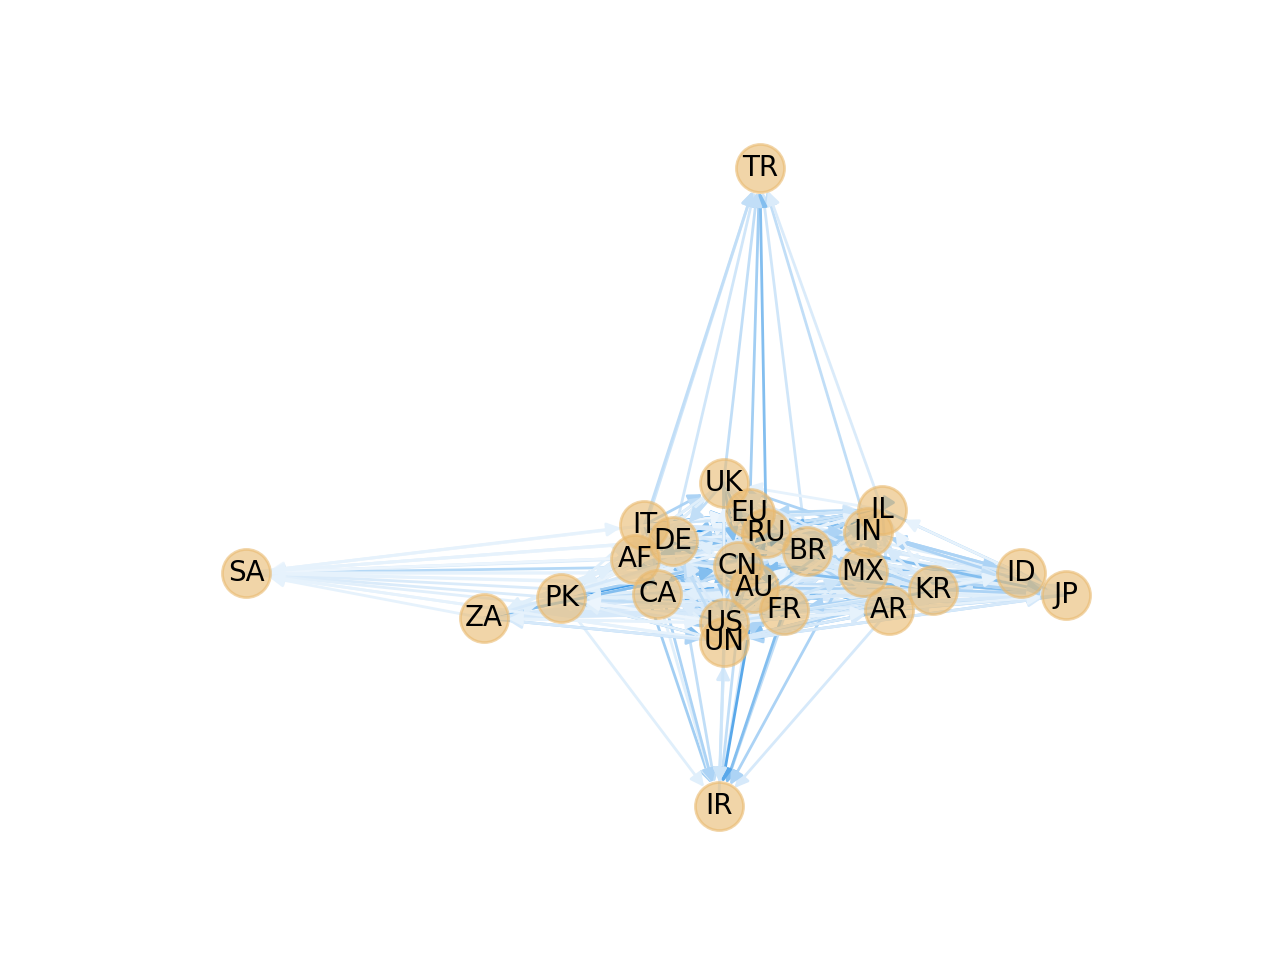

In [14]:
%matplotlib notebook
import networkx as nx
import matplotlib.pyplot as plt
from color_helper import shade_color

G = nx.DiGraph()
for c in countries:
    G.add_node(c)
for k, v in c2c.items():
    if v > 0.01:
        G.add_edge(k[0], k[1], weight=v)

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos,
                       node_color='#e9b96e', node_size=300, alpha=0.6)
for k, v in c2c.items():
    if v > 0.01:
        nx.draw_networkx_edges(G, pos,
                               edgelist=[(k[0], k[1])],
                               edge_color=[shade_color('#0a3050', v)])

nx.draw_networkx_labels(G,pos, font_size=10)

plt.axis('off')
plt.show()

### Creating the Graph of Countries Retweeting Each Other

To create a similar graph from retweets, we iterate through the tweets of each account (focused on only the last 120 days), and count the number of retweets of tweets by the other accounts. We normalize these values to defuse the impact of different frequencies of tweeting.

In [74]:
from datetime import datetime, timedelta


FOUR_MONTHS_AGO = datetime.strptime(accounts[-1].fetch_timestamp, '%Y-%m-%d %H:%M:%S.%f') - timedelta(days=120)

total_retweets = {a.twitter_handler.lower(): 0 for a in accounts}
country_retweets = {(a.twitter_handler.lower(), c): 0 for a in accounts for c in countries.keys()}
account_handlers = {a.twitter_handler.lower(): a for a in accounts}
for a1 in accounts:
    c1 = a1.country_representing
    if c1 not in countries:
        continue
    for t in a1.tweets:
        if datetime.strptime(t.created_at, '%a %b %d %H:%M:%S +0000 %Y') < FOUR_MONTHS_AGO:
            break
        if hasattr(t, 'retweeted_status') and t.retweeted_status:
            total_retweets[a1.twitter_handler.lower()] += 1
            a2_handler = t.retweeted_status.user.screen_name
            if a2_handler in account_handlers:
                c2 = account_handlers[a2_handler].country_representing
                if c2 in countries:
                    country_retweets[(a1.twitter_handler.lower(), c2)] += 1
                    if c2 != c1:
                        print(a1, c1, c2)

                    
c2c_retweets = {}
for c1 in countries.keys():
    for c2 in countries.keys():
        c2c_retweets[(c1, c2)] = 0
        for a in countries[c1]:
            if total_retweets[a.twitter_handler.lower()] > 0:
                c2c_retweets[(c1, c2)] += country_retweets[(a.twitter_handler.lower(), c2)] / total_retweets[a.twitter_handler.lower()] / len(countries[c1])


Argentina at the United Nations 🇦🇷 AR UN
Michel Temer 🇧🇷 BR AR
Aloysio Nunes 🇧🇷 BR CA
Marc-Andre Blanchard 🇨🇦 CA US
ValedeAlmeidaEU 🇪🇺 EU UN
ValedeAlmeidaEU 🇪🇺 EU UN
Israel Foreign Min. 🇮🇱 IL US
Ambassador Danon 🇮🇱 IL US
UN GA President 🇺🇳 UN FR


<IPython.core.display.Javascript object>


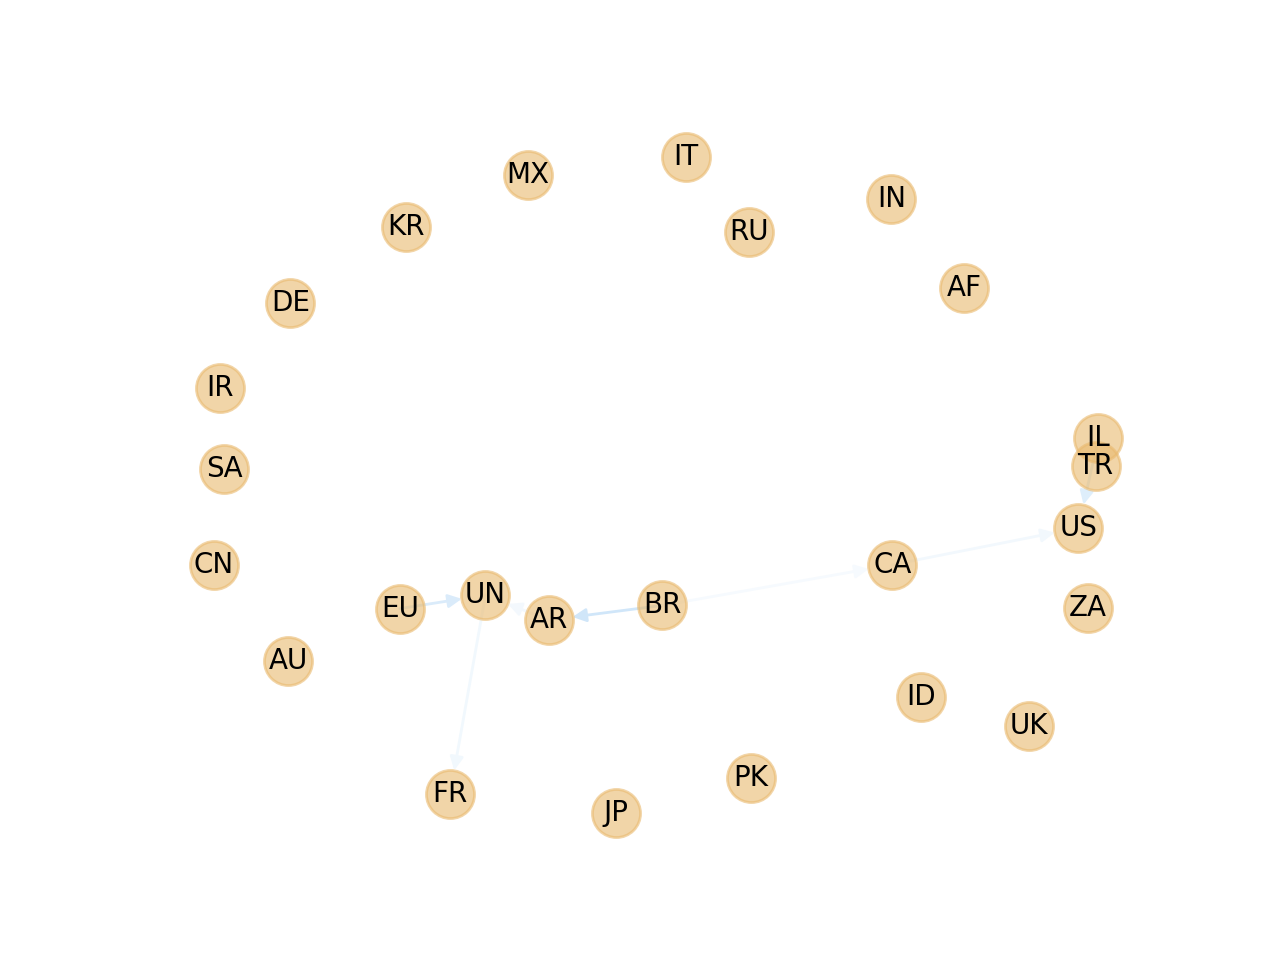

In [55]:
%matplotlib notebook
import networkx as nx
import matplotlib.pyplot as plt
from color_helper import shade_color

G = nx.DiGraph()
for c in countries:
    G.add_node(c)
for k, v in c2c_retweets.items():
    if v > 0.01:
        G.add_edge(k[0], k[1], weight=v)

pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx_nodes(G, pos,
                       node_color='#e9b96e', node_size=300, alpha=0.6)
for k, v in c2c_retweets.items():
    if v > 0.01:
        nx.draw_networkx_edges(G, pos,
                               edgelist=[(k[0], k[1])],
                               edge_color=[shade_color('#0a3050', v)])

nx.draw_networkx_labels(G,pos, font_size=10)

plt.axis('off')
plt.show()

In [75]:
import re

FOUR_MONTHS_AGO = datetime.strptime(accounts[-1].fetch_timestamp, '%Y-%m-%d %H:%M:%S.%f') - timedelta(days=120)

text = ""
url_remover = re.compile(r'http\S+')
for a1 in accounts:
    for t in a1.tweets:
        if datetime.strptime(t.created_at, '%a %b %d %H:%M:%S +0000 %Y') < FOUR_MONTHS_AGO:
            break
        s = t.text
        if s.startswith("RT "):
            s = s[3:]
        s = url_remover.sub('', s)
        if 'http' in s:
            print(s)
        text += " " + s


<IPython.core.display.Javascript object>


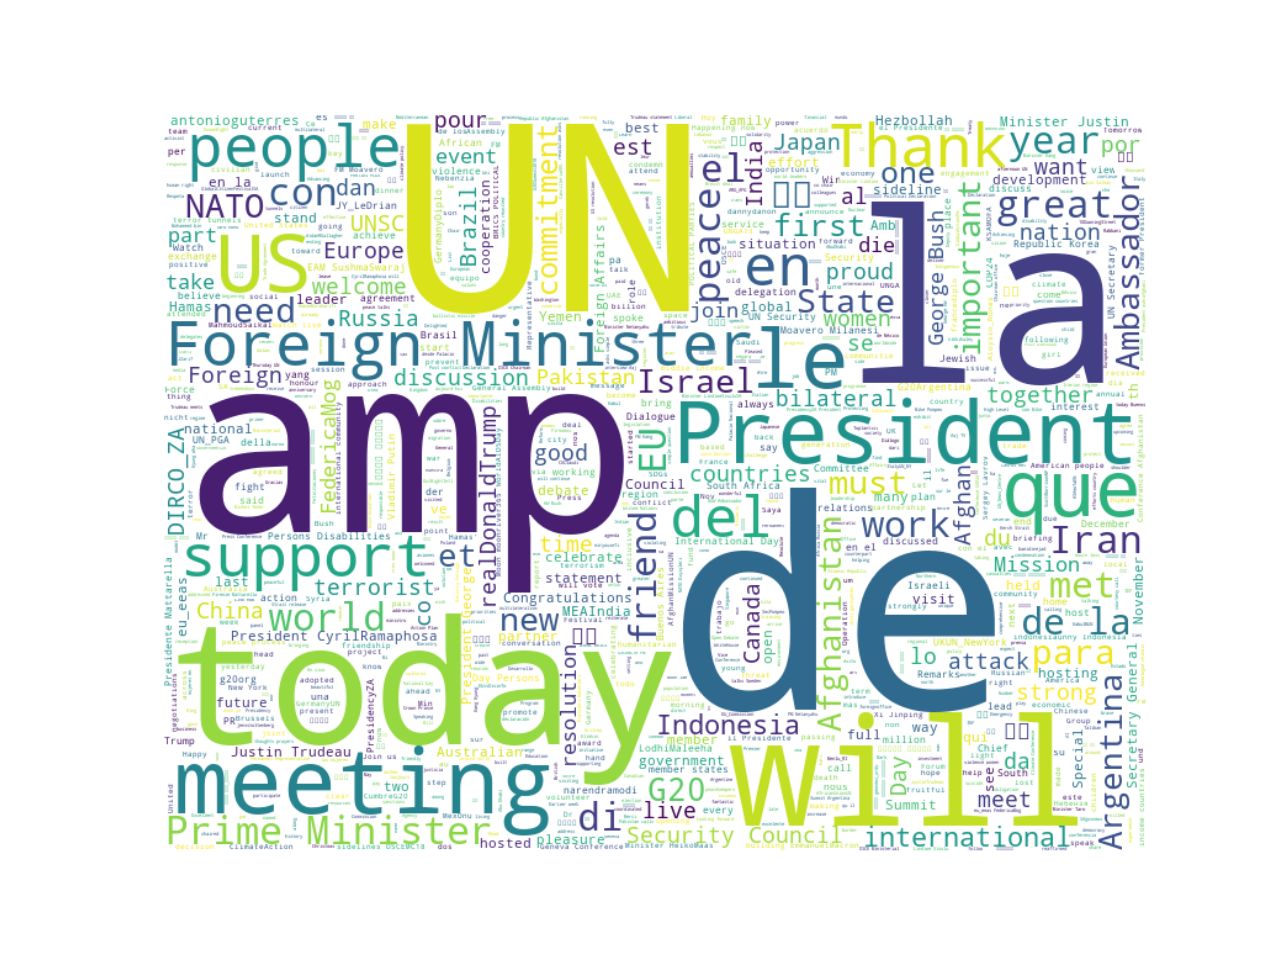

In [69]:
%matplotlib notebook
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color="white", max_words=1000, width=800, height=600).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Other Possible Queries

* hashtag cloud of tweets by accounts of a country
* hashtag/word cloud for a specific period of time
* graph of a subset of accounts following each other
* 🤔